## streamlit 과제

In [ ]:
"""
퇴사율 예측 모델 구현 가이드라인
1. 데이터 준비

 - 데이터셋: 'HR_comma_sep.csv' 파일을 사용합니다.
 - 주요 처리: 'Departments' 열 이름 수정 (공백 제거)
범주형 변수('Departments', 'salary')를 One-Hot Encoding으로 변환
drop_first=True 옵션을 사용하여 다중공선성 문제 방지


2. 특성 선택

- 선택된 특성:

satisfaction_level: 직원 만족도
number_project: 참여한 프로젝트 수
time_spend_company: 회사 근무 기간(년)

- 타겟 변수: 'left' (퇴사 여부 - 0: 잔류, 1: 퇴사)

3. 모델 선택 및 학습

- 모델: RandomForestClassifier
- 하이퍼파라미터:

n_estimators=100 (트리 개수)
random_state=42 (재현성 보장)

- 데이터 분할: 훈련 데이터 80%, 테스트 데이터 20% (random_state=42)
- 데이터 스케일링: StandardScaler 사용

4. Streamlit UI 구현

- 타이틀 및 설명: 퇴사 여부 예측 시스템 구현
- 사용자 입력 위젯:

- 만족도(satisfaction_level): slider 위젯 (0.0-1.0 범위)
- 프로젝트 수(number_project): number_input 위젯 (1-10 범위)
- 근무 연수(time_spend_company): number_input 위젯 (1-20 범위)


- 예측 기능: 버튼 클릭 시 예측 실행
- 결과 표시: 예측 결과(퇴사/잔류)와 확률 표시

- 퇴사 예측 시 빨간색 오류 메시지(st.error)
- 잔류 예측 시 녹색 성공 메시지(st.success)


5. 데이터 효율성

- 데이터 캐싱: @st.cache_data 데코레이터 사용하여 데이터 로드 함수 캐싱
(예시)
@st.cache_data # 함수의 입력 매개변수와 반환 값을 캐시에 저장하여 호출 시 재사용
def load_data():
    df = pd.read_csv('dataset/HR_comma_sep.csv')
    df.rename(columns={'Departments ': 'Departments'}, inplace=True)
    df = pd.get_dummies(df, columns=['Departments', 'salary'], drop_first=True)
    return df

- 입력 데이터 변환: 사용자 입력을 NumPy 배열로 변환 후 동일한 스케일러로 스케일링

6. 구현 시 고려사항

- 입력값 범위: 각 특성의 적절한 범위 설정 (데이터 분포 고려)
- 사용자 경험: 직관적인 UI 구성 및 명확한 결과 제시
- 모델 성능: 필요시 추가 특성 고려 (last_evaluation, average_montly_hours, Work_accident, promotion_last_5years)

7. 모델 평가 및 개선 방안

- 정확도 측정: model.score(X_test_scaled, y_test) 또는 accuracy_score() 사용
- 특성 중요도 시각화: model.feature_importances_ 값을 사용하여 st.bar_chart()로 시각화
- 추가 평가 지표: precision, recall, f1-score 등 계산 (classification_report 활용)

8. 구현 순서

- 데이터 로드 및 전처리 함수 구현
- 데이터 분할 및 스케일링
- 모델 학습
- Streamlit UI 구성
- 사용자 입력 처리 및 예측 기능 구현
- 결과 표시 및 시각화
"""

Model Accuracy: 96.90%
모델 성능 평가:

교차 검증 점수:
평균 정확도: 0.9681 (+/- 0.0136)

분류 리포트:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2294
           1       0.94      0.93      0.93       706

    accuracy                           0.97      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



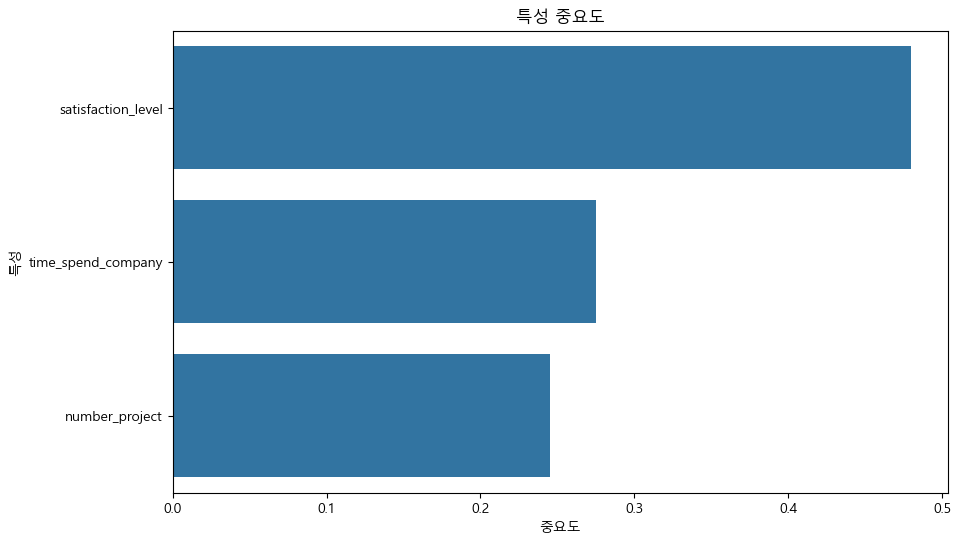

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 머신러닝 내용을 저장하고, 재호출시에 사용
import streamlit as st

# 1. 데이터 준비 , 2. 특성 선택
data = pd.read_csv('./dataset/HR_comma_sep.csv', encoding='cp949')

# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

X = data[['satisfaction_level', 'number_project', 'time_spend_company']]
y = data['left']

# 3. 모델 선택 및 학습
# 데이터 전처리: 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델 저장
#joblib.dump(rf_model, 'HR_comma_sep_model.pkl')

# 7. 모델 평가 및 개선 방안
# 테스트 데이터로 정확도 확인
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# 교차 검증 수행
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5)

# 특성 중요도 계산
feature_importance = pd.DataFrame({
    '특성': X.columns,
    '중요도': rf_model.feature_importances_
}).sort_values('중요도', ascending=False)

# 결과 출력
print("모델 성능 평가:")
print("\n교차 검증 점수:")
print(f"평균 정확도: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred))

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='중요도', y='특성', data=feature_importance)
plt.title('특성 중요도')
plt.show()

"""
5번 조건(데이터 효율성)에 대해서는 잘 모르겠습니다
"""